!pip install uproot

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import uproot
import pandas as pd
%matplotlib inline

# Generate toy data

New Physics model 'NP1' is Gaussian (0,1), SM is Gaussian (0.5,1)

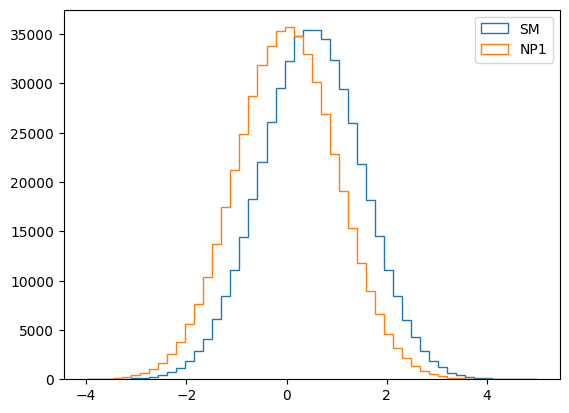

In [3]:
nEvents = 10**6
gNP1 = (0,1)
gSM = (0.5,1)

X = np.concatenate([np.random.normal(loc=gNP1[0],scale=gNP1[1], size=nEvents//2), 
     np.random.normal(loc=gSM[0],scale=gSM[1], size=nEvents//2)])
Y = np.concatenate([np.ones(nEvents//2), np.zeros(nEvents//2)])

plt.hist(X[Y==0], bins=50, histtype="step", range=(-4,5), label="SM")
plt.hist(X[Y==1], bins=50, histtype="step", range=(-4,5), label="NP1")
plt.legend()
plt.show()

### Train-Test Split

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X.reshape(-1,1) ,Y, train_size=nEvents//2, shuffle=True)

# Define likelihood ratio estimators

$$LR = \frac{P(data| NP_1)}{P(data| SM)}$$

In [5]:
# Since the data is Gaussian, we know the analytical form of the likelihood ratio
class trueLR:
    def predict(self, X):
        from scipy.stats import multivariate_normal
        #Evaluate the probability density function at point X
        rv_NP1 = multivariate_normal(0, 1).pdf
        rv_SM = multivariate_normal(0.5, 1).pdf
        LR = rv_NP1(X)/rv_SM(X)                                                        
        return LR
trueLR_model = trueLR()

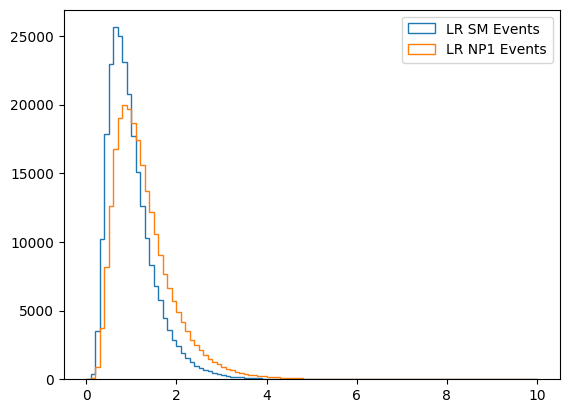

In [6]:
LR_SM_test = trueLR_model.predict(X=X_test[Y_test==0])
LR_NP1_test = trueLR_model.predict(X=X_test[Y_test==1])

plt.hist(LR_SM_test,
         bins=100, histtype="step", range=(0,10), label="LR SM Events")
plt.hist(LR_NP1_test,
         bins=100, histtype="step", range=(0,10), label="LR NP1 Events")
plt.legend()
plt.show()

In [9]:
print ("Combined LR SM: ",LR_SM_test.prod(), "Combined LR NP: ", LR_NP1_test.prod())
print ("Rreducing stats to only 100 events")
print ("Combined LR SM: ",LR_SM_test[:100].prod(), "Combined LR NP1: ", LR_NP1_test[:100].prod())

Combined LR SM:  0.0 Combined LR NP:  inf
Rreducing stats to only 100 events
Combined LR SM:  1.5082670837100581e-05 Combined LR NP1:  6989115114.622248


# Assume you expect to observe only 10 events in data

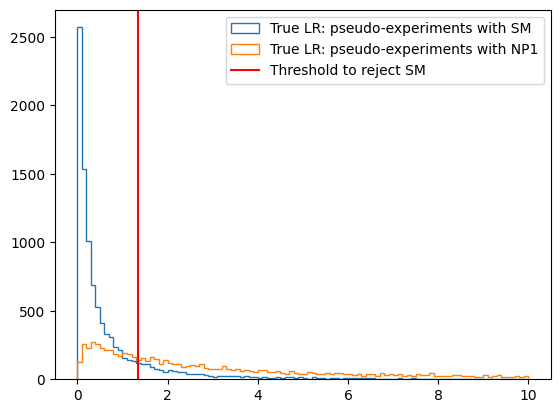

In [10]:
nData = 10
nPseudoExp = 10**4
dataset_LR_SM = LR_SM_test[:nPseudoExp*nData].reshape(nData,-1).prod(axis=0)
dataset_LR_NP1 = LR_NP1_test[:nPseudoExp*nData].reshape(nData,-1).prod(axis=0)

plt.hist(dataset_LR_SM,
         bins=100, histtype="step", range=(0,10), label="True LR: pseudo-experiments with SM")
plt.hist(dataset_LR_NP1,
         bins=100, histtype="step", range=(0,10), label="True LR: pseudo-experiments with NP1")
threshold = 1.35
plt.axvline(x = threshold, color = 'r', label = 'Threshold to reject SM')
plt.legend()
plt.show()

In [11]:
(dataset_LR_SM > threshold).sum() / dataset_LR_SM.shape[0], (dataset_LR_NP1 > threshold).sum() / dataset_LR_NP1.shape[0]

(0.1684, 0.7233)

# How to get this in a "Likelihood-Free" way ?

In [12]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

inputs = Input(shape=(X_train.shape[1],))
D = Dense(256, activation="relu")(inputs) # first layer
D = Dense(256, activation="relu")(D) 
D = Dense(1, activation="sigmoid")(D) # last layer
clf = Model(inputs=inputs, outputs=D)

clf.compile(loss="binary_crossentropy", optimizer="adam")

In [13]:
clf.fit(x=X_train, y=Y_train, epochs=10, batch_size=1024)

Epoch 1/10
489/489 [==============================] - 7s 4ms/step - loss: 0.6635
Epoch 2/10
489/489 [==============================] - 2s 5ms/step - loss: 0.6633
Epoch 3/10
489/489 [==============================] - 2s 4ms/step - loss: 0.6633
Epoch 4/10
489/489 [==============================] - 2s 5ms/step - loss: 0.6632
Epoch 5/10
489/489 [==============================] - 2s 5ms/step - loss: 0.6633
Epoch 6/10
489/489 [==============================] - 2s 5ms/step - loss: 0.6632
Epoch 7/10
489/489 [==============================] - 2s 5ms/step - loss: 0.6632
Epoch 8/10
489/489 [==============================] - 2s 5ms/step - loss: 0.6632
Epoch 9/10
489/489 [==============================] - 2s 5ms/step - loss: 0.6632
Epoch 10/10
489/489 [==============================] - 2s 5ms/step - loss: 0.6632


In [33]:
# Overtrained classifier example

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

inputs = Input(shape=(X_train.shape[1],))
D = Dense(256, activation="linear")(inputs) # first layer
D = Dense(256, activation="linear")(D) 
D = Dense(1, activation="sigmoid")(D) # last layer
clf = Model(inputs=inputs, outputs=D)

clf.compile(loss="binary_crossentropy", optimizer="adam")

nTrainSmall = 5* 10**2
clf.fit(x=X_train[:nTrainSmall], y=Y_train[:nTrainSmall],
        epochs=10, batch_size=512)



Epoch 1/10
1/1 [==============================] - 0s 254ms/step - loss: 0.7142
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6777
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6778
Epoch 4/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6877
Epoch 5/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6891
Epoch 6/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6837
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.6777
Epoch 8/10
1/1 [==============================] - 0s 4ms/step - loss: 0.6751
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6765
Epoch 10/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6793


$$ LR = \frac{s}{1-s} $$

In [34]:
y_pred = clf.predict(X_test, batch_size=4000).ravel()

125/125 [==============================] - 0s 2ms/step


In [35]:
lr_pred = y_pred/(1-y_pred)

In [36]:
LR_pred_SM_test = lr_pred[Y_test==0]
LR_pred_NP1_test = lr_pred[Y_test==1]

Let's see how close the estimated LRs are to the truth

In [37]:
print("SM data")
print ("True LR: ", LR_SM_test[:5], "\nPred LR: ", LR_pred_SM_test[:5])
print("NP1 data")
print ("True LR: ", LR_NP1_test[:5], "\nPred LR: ", LR_pred_NP1_test[:5])


SM data
True LR:  [1.734788   1.24787332 0.43704626 1.50099212 0.99343422] 
Pred LR:  [1.4397308 1.2700514 0.8519235 1.3625646 1.1644809]
NP1 data
True LR:  [1.09966412 0.80787593 2.90503511 0.95352374 1.50315564] 
Pred LR:  [1.2103865 1.076337  1.7518691 1.1464509 1.3632711]


# Uses: 
- **Hypothesis testing**
- Negative weighted events: reweight MC with negative weights into MC with only positive weights
- Re-weighing Pythia to Herwig etc
- Unfolding

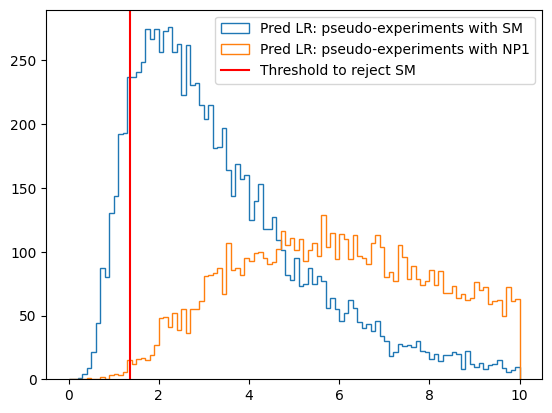

In [38]:
# Same as before, but now the estimated LR coems from the classifier
nData = 10
nPseudoExp = 10**4
dataset_pred_LR_SM = LR_pred_SM_test[:nPseudoExp*nData].reshape(nData,-1).prod(axis=0)
dataset_pred_LR_NP1 = LR_pred_NP1_test[:nPseudoExp*nData].reshape(nData,-1).prod(axis=0)

plt.hist(dataset_pred_LR_SM,
         bins=100, histtype="step", range=(0,10), label="Pred LR: pseudo-experiments with SM")
plt.hist(dataset_pred_LR_NP1,
         bins=100, histtype="step", range=(0,10), label="Pred LR: pseudo-experiments with NP1")
threshold = 1.35
plt.axvline(x = threshold, color = 'r', label = 'Threshold to reject SM')
plt.legend()
plt.show()

But is this estimate good enough? Is it accurate everywhere? 
What if we have a bias in some phase space? 

Need to visualise the LR leant, so flip the classifier into a 'generative model'

## Diagnostics: Re-weighting SM events to look like NP1

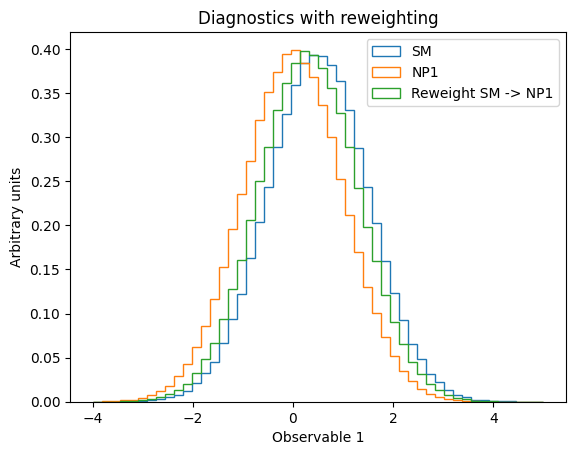

In [39]:
weights = lr_pred

plt.hist(X_test[Y_test==0], bins=50, histtype="step", density=1, range=(-4,5), label="SM")
plt.hist(X_test[Y_test==1], bins=50, histtype="step", density=1, range=(-4,5), label="NP1")
plt.hist(X_test[Y_test==0], weights=weights[Y_test==0], bins=50, histtype="step", density=1, range=(-4,5), label="Reweight SM -> NP1")
plt.legend()
plt.xlabel("Observable 1")
plt.ylabel("Arbitrary units")
plt.title("Diagnostics with reweighting")
#plt.savefig("reweight.pdf")
plt.show()

## Diagnostics: Calibration curve

In [40]:
# predictions on training set
y_pred_train = clf.predict(X_train, batch_size=4*1024).ravel()

123/123 [==============================] - 0s 2ms/step


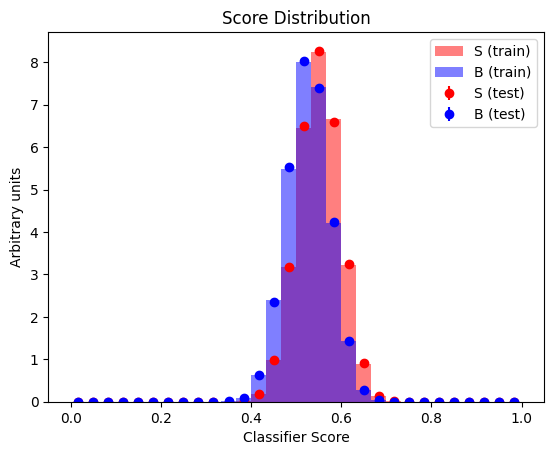

In [41]:
from extra_functions import compare_train_test

compare_train_test(
    y_pred_train,
    Y_train,
    y_pred,
    Y_test,
    xlabel="Classifier Score",
    title="Score Distribution",
)

### Now for calibration curve, we scan over different thresholds and plot the purity. 
Purity of NP1 events for a given threshold cut is nNP1/(nNP1+nSM) that pass the cut.

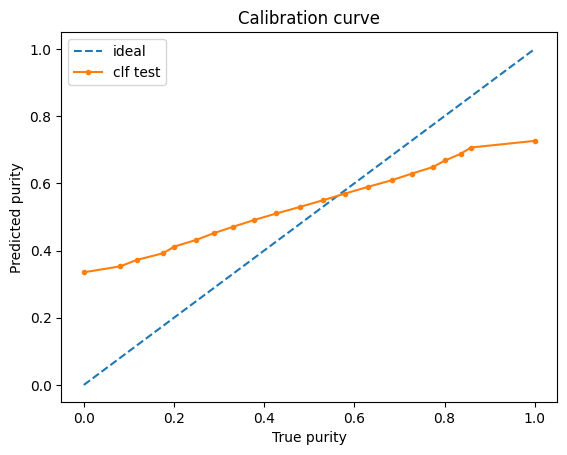

In [42]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(Y_test, y_pred, n_bins=50)
plt.plot([0, 1], [0, 1], linestyle='--', label='ideal')
plt.plot(prob_true, prob_pred, marker='.', label='clf test')
# prob_true, prob_pred = calibration_curve(Y_train, y_pred_train, n_bins=50)
# plt.plot(prob_true, prob_pred, marker='.', label='clf train')
plt.legend()
plt.title("Calibration curve")
plt.xlabel("True purity")
plt.ylabel("Predicted purity")
plt.show()

## Exercise:
- Try plots with a poorly trained classifier

## Optional:
- Try 2D Gaussian models for SM and NP1

# Now on physics dataset

We will assume that B is H_0 and S is H_1 (even though actually H1 as S+B makes more sense)

In [45]:
# same data & data loading code as S vs B tutorial
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

filename = "dataFiles/dataWW_d1.root"
file = uproot.open(filename)

# show what is inside the root file loaded from uproot
print(file.classnames())
print(file.keys())

tree = file["tree_event"]  # select the TTree inside the root file
dfall = tree.arrays(library="pd")  # convert uproot TTree into pandas dataframe

label_weights = (dfall[dfall.label == 0].mcWeight.sum(), dfall[dfall.label == 1].mcWeight.sum())
fulldata = dfall[
    #(dfall.lep_n == 2) & (dfall.mcWeight > 0)
    (dfall.lep_n == 2)
]  # only keep events with exactly two leptons

target = fulldata["label"]
weights = fulldata["mcWeight"]

#true_class_weights = [weights[target == 0].sum(), weights[target == 1].sum()]

featureList = ['met_et', 'met_phi', 'lep_n',
       'lep_pt_0', 'lep_pt_1', 'lep_eta_0', 'lep_eta_1', 'lep_phi_0',
       'lep_phi_1', 'lep_E_0', 'lep_E_1', 'lep_charge_0', 'lep_charge_1',
       'lep_type_0', 'lep_type_1', 'jet_n', 'jet_pt_0', 'jet_pt_1',
       'jet_eta_0', 'jet_eta_1', 'jet_phi_0', 'jet_phi_1', 'jet_E_0',
       'jet_E_1']
data = pd.DataFrame(fulldata, columns=featureList)


{'tree_event;1': 'TTree'}
['tree_event;1']


In [46]:
train_size = 0.75  # fraction of sample used for training

XP_train, XP_test, yP_train, yP_test, weightsP_train, weightsP_test = train_test_split(
    data, target, weights, train_size=train_size)

In [47]:
prec = 2

scalerP = StandardScaler()
XP_train = scalerP.fit_transform(XP_train)
XP_test = scalerP.transform(XP_test)

class_weights_train = (weightsP_train[yP_train == 0].sum(), weightsP_train[yP_train == 1].sum())

for i in range(len(class_weights_train)):
    weightsP_train[yP_train == i] *= (
        max(class_weights_train) / class_weights_train[i]
    )  # equalize number of background and signal event

In [48]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

inputs = Input(shape=(XP_train.shape[1],))
C = Dense(1024, activation="relu")(inputs) # first layer
C = Dense(1024, activation="relu")(C) 
C = Dense(1, activation="sigmoid")(C) # last layer
model = Model(inputs=inputs, outputs=C)

model.compile(loss="binary_crossentropy", optimizer="adam")

In [49]:
model.fit(x=XP_train, y=yP_train, epochs=10, batch_size=1024)

Epoch 1/10
437/437 [==============================] - 2s 5ms/step - loss: 0.3741
Epoch 2/10
437/437 [==============================] - 2s 5ms/step - loss: 0.3151
Epoch 3/10
437/437 [==============================] - 2s 5ms/step - loss: 0.2994
Epoch 4/10
437/437 [==============================] - 2s 5ms/step - loss: 0.2929
Epoch 5/10
437/437 [==============================] - 2s 5ms/step - loss: 0.2884
Epoch 6/10
437/437 [==============================] - 2s 5ms/step - loss: 0.2856
Epoch 7/10
437/437 [==============================] - 2s 5ms/step - loss: 0.2832
Epoch 8/10
437/437 [==============================] - 2s 5ms/step - loss: 0.2814
Epoch 9/10
437/437 [==============================] - 2s 5ms/step - loss: 0.2791
Epoch 10/10
437/437 [==============================] - 2s 5ms/step - loss: 0.2774


In [50]:
yP_pred = model.predict(XP_test, batch_size=4*1024).ravel()
yP_train_pred = model.predict(XP_train, batch_size=4*1024).ravel()
lrP_pred = yP_pred/(1-yP_pred)

110/110 [==============================] - 0s 1ms/step


## Typical plots

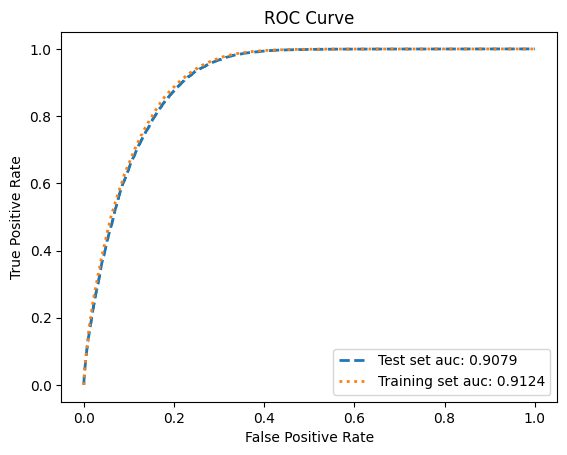

In [51]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# easier to remove negative weighted events for fast AUC calucaltion
posWeightsTrain, posWeightsTest = weightsP_train>0, weightsP_test>0

fpr_test, tpr_test, _ = roc_curve(y_true=yP_test[posWeightsTest],
                                  y_score=yP_pred[posWeightsTest], 
                                  sample_weight=weightsP_test[posWeightsTest])
fpr_train, tpr_train, _ = roc_curve(y_true=yP_train[posWeightsTrain],
                                    y_score=yP_train_pred[posWeightsTrain], 
                                    sample_weight=weightsP_train[posWeightsTrain])
auc_test = roc_auc_score(y_true=yP_test[posWeightsTest], 
                         y_score=yP_pred[posWeightsTest],
                         sample_weight=weightsP_test[posWeightsTest])
auc_train = roc_auc_score(y_true=yP_train[posWeightsTrain],
                          y_score=yP_train_pred[posWeightsTrain],
                          sample_weight=weightsP_train[posWeightsTrain])
plt.plot(fpr_test, tpr_test, color='tab:blue', lw=2, ls="--", label=f"Test set auc: {auc_test:.4f}")
plt.plot(fpr_train, tpr_train, color='tab:orange', lw=2, ls=":", label=f"Training set auc: {auc_train:.4f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

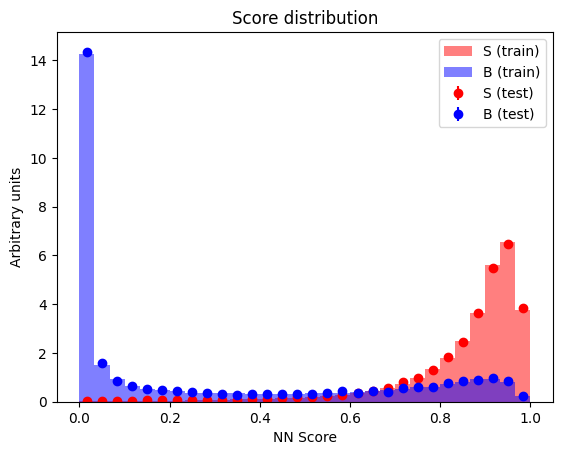

In [52]:
from extra_functions import compare_train_test

compare_train_test(
    yP_train_pred,
    yP_train,
    yP_pred,
    yP_test,
    xlabel="NN Score",
    title="Score distribution",
    weights_train=weightsP_train.values,
    weights_test=weightsP_test.values,
)

## Advanced Diagnostics

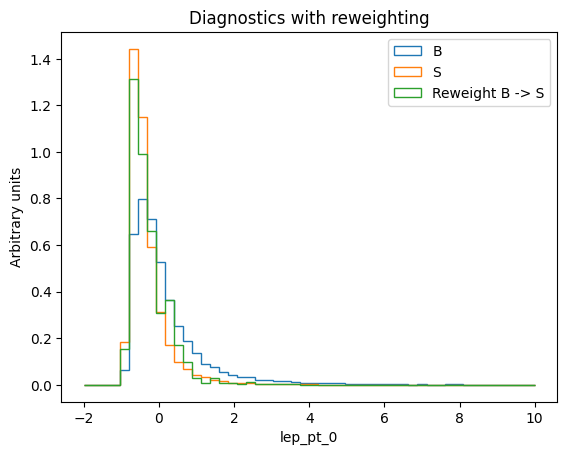

In [56]:
reweights = weightsP_test * lrP_pred
f = 3; rangee = (-2,10)  # which observable to plot, what range
plt.hist(XP_test[yP_test==0, f], weights=weightsP_test[yP_test==0], 
         bins=50, range=rangee, histtype="step", density=1, label="B")
plt.hist(XP_test[yP_test==1, f], weights=weightsP_test[yP_test==1], 
         bins=50, range=rangee, histtype="step", density=1, label="S")
plt.hist(XP_test[yP_test==0, f], weights=reweights[yP_test==0], 
         bins=50, range=rangee, histtype="step", density=1, label="Reweight B -> S")
plt.xlabel(featureList[f])
plt.ylabel("Arbitrary units")
plt.title("Diagnostics with reweighting")
plt.legend()
plt.show()

# try plotting f=4, how would you improve it?

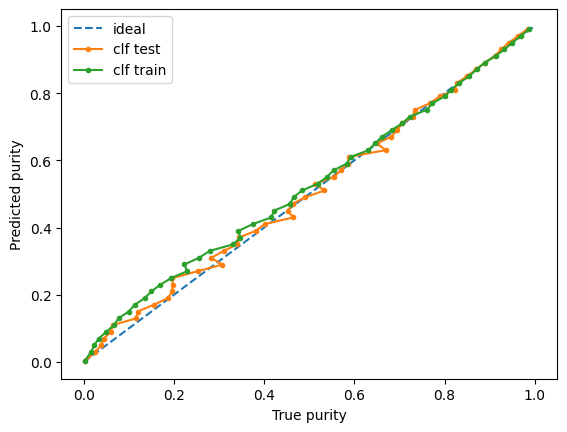

In [55]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(yP_test, yP_pred, n_bins=50)
plt.plot([0, 1], [0, 1], linestyle='--', label='ideal')
plt.plot(prob_true, prob_pred, marker='.', label='clf test')
prob_true, prob_pred = calibration_curve(yP_train, yP_train_pred, n_bins=50)
plt.plot(prob_true, prob_pred, marker='.', label='clf train')
plt.legend()
plt.xlabel("True purity")
plt.ylabel("Predicted purity")
plt.show()

## Exercise:
- How can we improve the performance? Preprocessing & HPO, regularization (dropouts), early-stopping
- Ensembling

## Optional:
- Investigate phase space with poor performance

# Omnifold: Multi-dimensional unbinned unfolding
Content borrowed from Vinicius Mikuni (https://github.com/usatlas-ml-training/lbnl-2023/blob/main/unfolding/DIS_Omnifold-sol.ipynb)

In [ ]:
import omnifold as of

In [ ]:
N_Events = 10**5

# Synthetic
theta0_G = np.random.normal(0.2, 0.8, N_Events)  # Generator-level synthetic sample
theta0_S = np.array([(x + np.random.normal(0, 0.5)) for x in theta0_G])  # Detector smearing for synthetic sample

theta0 = np.stack([theta0_G, theta0_S], axis=1)

# Natural
theta_unknown_G = np.random.normal(0, 1, N_Events)
theta_unknown_S = np.array([(x + np.random.normal(0, 0.5)) for x in theta_unknown_G])

In [ ]:
_, _, _ = plt.hist(theta0_G, bins=np.linspace(-3, 3, 20), color='blue', alpha=0.5, label="MC, true")
_, _, _ = plt.hist(theta0_S, bins=np.linspace(-3, 3, 20), histtype="step", color='black', ls=':', label="MC, reco")
_, _, _ = plt.hist(theta_unknown_G, bins=np.linspace(-3, 3, 20), color='orange', alpha=0.5, label="Data, true")
_, _, _ = plt.hist(theta_unknown_S, bins=np.linspace(-3, 3, 20), histtype="step", color='black', label="Data, reco")
plt.xlabel("x")
plt.ylabel("events")
plt.legend(frameon=False)

### Define the Model Architecture

In [ ]:
inputs = Input((1,))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model_gaus = Model(inputs=inputs, outputs=outputs)

In [ ]:
N_Iterations = 2
myweights = of.omnifold(theta0_G, theta0_S, theta_unknown_S, N_Iterations, model_gaus)

### Plot unfolded distributions

In [ ]:
_, _, _ = plt.hist(theta0_G, bins=np.linspace(-3, 3, 20), color='blue', alpha=0.5, label="MC, true")
_, _, _ = plt.hist(theta_unknown_G, bins=np.linspace(-3, 3, 20), color='orange', alpha=0.5, label="Data, true")
_, _, _ = plt.hist(
    theta0_G,
    weights=myweights[-1, 1, :],
    bins=np.linspace(-3, 3, 20),
    color='black',
    histtype="step",
    label="OmniFolded",
    lw=2,
)
plt.xlabel("x")
plt.ylabel("events")
plt.legend(frameon=False)

### Plot the distribution at reco level instead of gen level

In [ ]:
_,_,_=plt.hist(theta0_S,bins=np.linspace(-3,3,20),color='blue',alpha=0.5,label="MC, reco")
_,_,_=plt.hist(theta_unknown_S,bins=np.linspace(-3,3,20),color='orange',alpha=0.5,label="Data, reco")
_,_,_=plt.hist(theta0_S,weights=myweights[-1, 1, :], bins=np.linspace(-3,3,20),color='black',histtype="step",label="OmniFolded",lw=2)
plt.xlabel("x")
plt.ylabel("events")
plt.legend(frameon=False)